In [5]:
import os

# Define dataset root path
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN"

# Define processed image paths
processed_folder = os.path.join(dataset_path, "Processed_Images")
image_folder = os.path.join(processed_folder, "images")
mask_folder = os.path.join(processed_folder, "masks")

# ✅ Create necessary directories if they don’t exist
os.makedirs(processed_folder, exist_ok=True)
os.makedirs(image_folder, exist_ok=True)
os.makedirs(mask_folder, exist_ok=True)

# ✅ Verify dataset structure
folders = ["TRAIN", "VAL", "TEST"]
for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.exists(folder_path):
        print(f"✅ Found: {folder}")
    else:
        print(f"❌ Missing: {folder}")

print("✅ Dataset structure verified. Now ready for image processing!")


✅ Found: TRAIN
✅ Found: VAL
✅ Found: TEST
✅ Dataset structure verified. Now ready for image processing!


 Load Original Images

In [8]:
import os
import numpy as np
import cv2
import json
from tensorflow.keras.preprocessing.image import save_img

# ✅ Define dataset directories
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN"
processed_folder = os.path.join(dataset_path, "Processed_Images")
original_folder = os.path.join(processed_folder, "original")
overlay_folder = os.path.join(processed_folder, "overlay")

# ✅ Create folders if they don’t exist
os.makedirs(original_folder, exist_ok=True)
os.makedirs(overlay_folder, exist_ok=True)

# ✅ Load annotation JSON
annotation_file = os.path.join(dataset_path, "annotations_all.json")

with open(annotation_file, "r") as f:
    annotations = json.load(f)

# ✅ Overlay Parameters
alpha = 0.6  # Transparency level for overlay

# ✅ Function to create mask from annotation
def create_mask_from_annotation(annotation, original_size):
    h_orig, w_orig = original_size  # Preserve original dimensions
    mask = np.zeros((h_orig, w_orig), dtype=np.uint8)
    contour_list = []

    for region in annotation["regions"]:
        shape_attr = region["shape_attributes"]
        
        if shape_attr["name"] == "polygon":
            all_x = np.array(shape_attr["all_points_x"])
            all_y = np.array(shape_attr["all_points_y"])

            # Ensure coordinates stay within the image bounds
            all_x = np.clip(all_x, 0, w_orig - 1)
            all_y = np.clip(all_y, 0, h_orig - 1)

            # Convert to contour format
            contour = np.array(list(zip(all_x, all_y)), dtype=np.int32)
            contour_list.append(contour)

            # Draw the tumor mask
            cv2.fillPoly(mask, [contour], 255)

    return mask, contour_list

# ✅ Process all images from TRAIN, TEST, and VAL folders
for folder in ["TRAIN", "TEST", "VAL"]:
    folder_path = os.path.join(dataset_path, folder)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # ✅ Check if it's a valid image
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        # ✅ Load the original image without resizing
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Skipping {img_name}, unable to read.")
            continue

        original_size = img.shape[:2]  # Store original height & width

        # ✅ Save original image (preserving aspect ratio)
        save_img(os.path.join(original_folder, img_name), np.expand_dims(img, axis=-1))

        # ✅ Extract base filename for lookup in JSON
        base_filename = os.path.splitext(img_name)[0]  
        matching_key = next((key for key in annotations.keys() if base_filename in key), None)

        if matching_key:
            mask, contours = create_mask_from_annotation(annotations[matching_key], original_size)

            # ✅ Convert grayscale image to 3-channel for overlaying
            img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            # ✅ Create an overlay mask
            colored_mask = np.zeros_like(img_color)
            colored_mask[:, :, 2] = mask  # Apply mask in **Red** channel

            # ✅ Blend overlay with the original image
            overlayed_image = cv2.addWeighted(img_color, 1, colored_mask, alpha, 0)

            # ✅ Draw tumor boundary in **Blue**
            cv2.polylines(overlayed_image, contours, isClosed=True, color=(0, 0, 255), thickness=2)

            # ✅ Add label near the tumor
            if len(contours) > 0:
                M = cv2.moments(contours[0])
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    cv2.putText(overlayed_image, "Tumor Detected", (cX - 5, cY - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2, cv2.LINE_AA)

            # ✅ Save overlay image
            save_img(os.path.join(overlay_folder, img_name), overlayed_image)

print(f"✅ All original images saved in: {original_folder}")
print(f"✅ All overlay images saved in: {overlay_folder}")
    

✅ All original images saved in: C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\original
✅ All overlay images saved in: C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\overlay


In [17]:
# actually iske baad me kuch steps hai jaise overlay folder ...final overlay folder final original folder ..augmentation...train test validation..

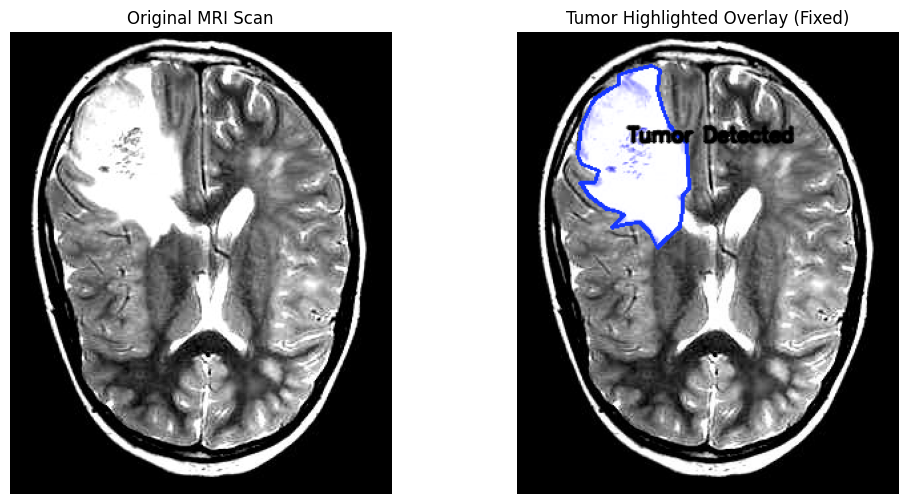

In [9]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ✅ Path to the dataset and annotation file
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN"
annotation_file = os.path.join(dataset_path, "annotations_all.json")

# ✅ Load annotation data
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# ✅ Define a sample image (Modify this to test other images)
sample_image_name = "y0.jpg"  
sample_image_path = os.path.join(dataset_path, "TRAIN", sample_image_name)

# ✅ Load the original image without resizing
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
if sample_image is None:
    raise ValueError(f"Image {sample_image_name} not found or unable to load!")

original_size = sample_image.shape[:2]  # Get original image size (height, width)

# ✅ Normalize image for better visualization
sample_image = cv2.normalize(sample_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# ✅ Extract annotation key from JSON (Find the closest match)
matching_key = next((key for key in annotations.keys() if sample_image_name in key), None)
if not matching_key:
    raise ValueError(f"No matching annotation found for {sample_image_name}!")

sample_annotation = annotations[matching_key]  # Get corresponding annotation data

# ✅ Function to create a mask using the original image size
def create_mask_from_annotation(annotation, original_size):
    h_orig, w_orig = original_size  # Preserve original dimensions
    mask = np.zeros((h_orig, w_orig), dtype=np.uint8)
    contour_list = []  # Store contours for tumor boundary

    for region in annotation["regions"]:
        shape_attr = region["shape_attributes"]
        
        if shape_attr["name"] == "polygon":
            all_x = np.array(shape_attr["all_points_x"])
            all_y = np.array(shape_attr["all_points_y"])

            # **Ensure the annotation fits within the image dimensions**
            all_x = np.clip(all_x, 0, w_orig - 1)
            all_y = np.clip(all_y, 0, h_orig - 1)

            # Convert to contour format
            contour = np.array(list(zip(all_x, all_y)), dtype=np.int32)
            contour_list.append(contour)

            # Draw the tumor mask
            cv2.fillPoly(mask, [contour], 255)

    return mask, contour_list

# ✅ Generate tumor mask & contour using original size
sample_mask, contours = create_mask_from_annotation(sample_annotation, original_size)

# ✅ Convert grayscale image to 3-channel for overlaying
overlay_image = cv2.cvtColor(sample_image, cv2.COLOR_GRAY2BGR)

# ✅ Create an overlay with tumor annotation
colored_mask = np.zeros_like(overlay_image)
colored_mask[:, :, 2] = sample_mask  # Apply mask in **Red** channel

# ✅ Blend overlay with the original image
overlayed_image = cv2.addWeighted(overlay_image, 1, colored_mask, 0.6, 0)

# ✅ Draw tumor boundary in **Blue**
cv2.polylines(overlayed_image, contours, isClosed=True, color=(22, 55, 255), thickness=2)

# ✅ Add label near the tumor
if len(contours) > 0:
    M = cv2.moments(contours[0])
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(overlayed_image, "Tumor Detected", (cX - 5, cY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2, cv2.LINE_AA)

# ✅ Display results
plt.figure(figsize=(12, 6))

# Original MRI scan
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap="gray")
plt.title("Original MRI Scan")
plt.axis("off")

# Overlayed MRI Scan with label and border
plt.subplot(1, 2, 2)
plt.imshow(overlayed_image)
plt.title("Tumor Highlighted Overlay (Fixed)")
plt.axis("off")

plt.show()


In [102]:
import os
import numpy as np
import cv2
import json
from tensorflow.keras.preprocessing.image import save_img

# ✅ Define dataset directories
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN"
processed_folder = os.path.join(dataset_path, "Processed_Images")
original_folder = os.path.join(processed_folder, "original")
overlay_folder = os.path.join(processed_folder, "overlay")

# ✅ Create folders if they don’t exist
os.makedirs(original_folder, exist_ok=True)
os.makedirs(overlay_folder, exist_ok=True)

# ✅ Load annotation JSON
annotation_file = os.path.join(dataset_path, "annotations_all.json")

with open(annotation_file, "r") as f:
    annotations = json.load(f)

# ✅ Overlay Parameters
alpha = 0.6  # Transparency level for overlay

# ✅ Function to create mask from annotation
def create_mask_from_annotation(annotation, original_size):
    h_orig, w_orig = original_size  # Preserve original dimensions
    mask = np.zeros((h_orig, w_orig), dtype=np.uint8)
    contour_list = []

    for region in annotation["regions"]:
        shape_attr = region["shape_attributes"]
        
        if shape_attr["name"] == "polygon":
            all_x = np.array(shape_attr["all_points_x"])
            all_y = np.array(shape_attr["all_points_y"])

            # Ensure coordinates stay within the image bounds
            all_x = np.clip(all_x, 0, w_orig - 1)
            all_y = np.clip(all_y, 0, h_orig - 1)

            # Convert to contour format
            contour = np.array(list(zip(all_x, all_y)), dtype=np.int32)
            contour_list.append(contour)

            # Draw the tumor mask
            cv2.fillPoly(mask, [contour], 255)

    return mask, contour_list

# ✅ Process all images from TRAIN, TEST, and VAL folders
for folder in ["TRAIN", "TEST", "VAL"]:
    folder_path = os.path.join(dataset_path, folder)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # ✅ Check if it's a valid image
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        # ✅ Load the original image without resizing
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Skipping {img_name}, unable to read.")
            continue

        original_size = img.shape[:2]  # Store original height & width

        # ✅ Save original image (preserving aspect ratio)
        save_img(os.path.join(original_folder, img_name), np.expand_dims(img, axis=-1))

        # ✅ Extract base filename for lookup in JSON
        base_filename = os.path.splitext(img_name)[0]  
        matching_key = next((key for key in annotations.keys() if base_filename in key), None)

        if matching_key:
            mask, contours = create_mask_from_annotation(annotations[matching_key], original_size)

            # ✅ Convert grayscale image to 3-channel for overlaying
            img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            # ✅ Create an overlay mask
            colored_mask = np.zeros_like(img_color)
            colored_mask[:, :, 2] = mask  # Apply mask in **Red** channel

            # ✅ Blend overlay with the original image
            overlayed_image = cv2.addWeighted(img_color, 1, colored_mask, alpha, 0)

            # ✅ Draw tumor boundary in **Blue**
            cv2.polylines(overlayed_image, contours, isClosed=True, color=(0, 0, 255), thickness=2)

            # ✅ Add label near the tumor
            if len(contours) > 0:
                M = cv2.moments(contours[0])
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    cv2.putText(overlayed_image, "Tumor Detected", (cX - 5, cY - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

            # ✅ Save overlay image
            save_img(os.path.join(overlay_folder, img_name), overlayed_image)

print(f"✅ All original images saved in: {original_folder}")
print(f"✅ All overlay images saved in: {overlay_folder}")
    

KeyboardInterrupt: 

In [10]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import save_img

# ✅ Define dataset directories
processed_folder = os.path.join(dataset_path, "Processed_Images")
original_folder = os.path.join(processed_folder, "original")
overlay_folder = os.path.join(processed_folder, "overlay")
final_original_folder = os.path.join(processed_folder, "final_original")
final_overlay_folder = os.path.join(processed_folder, "final_overlay")

# ✅ Create necessary directories
os.makedirs(final_original_folder, exist_ok=True)
os.makedirs(final_overlay_folder, exist_ok=True)

# ✅ Target size (256x256) - Ensuring consistency
target_size = (256, 256)

# ✅ Function to resize both images while preserving alignment
def resize_pair(image, overlay, target_size):
    image_resized = cv2.resize(image, target_size)
    overlay_resized = cv2.resize(overlay, target_size)
    return image_resized, overlay_resized

# ✅ Process all images in the original and overlay folders
for img_name in os.listdir(original_folder):
    img_path = os.path.join(original_folder, img_name)
    overlay_path = os.path.join(overlay_folder, img_name)

    # ✅ Load images
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    overlay = cv2.imread(overlay_path, cv2.IMREAD_COLOR)

    if img is None or overlay is None:
        print(f"⚠️ Skipping {img_name}, unable to read.")
        continue

    # ✅ Resize both images together
    img_resized, overlay_resized = resize_pair(img, overlay, target_size)

    # ✅ Save resized images
    save_img(os.path.join(final_original_folder, img_name), np.expand_dims(img_resized, axis=-1))
    save_img(os.path.join(final_overlay_folder, img_name), overlay_resized)

print(f"✅ All resized original images saved in: {final_original_folder}")
print(f"✅ All resized overlay images saved in: {final_overlay_folder}")


✅ All resized original images saved in: C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\final_original
✅ All resized overlay images saved in: C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\final_overlay


In [ ]:
# Augmentations

 Load Annotations and Perform Augmentation
 Albumentations Library for augmentation
Apply same transformation to both image and mask.
Augmentations:
Rotation
Horizontal & Vertical Flipping
Random Brightness/Contrast
Elastic Deformation
Gaussian Noise
CLAHE (Histogram Equalization)

In [11]:
import os
import numpy as np
import cv2
import json
import albumentations as A
from tensorflow.keras.preprocessing.image import save_img


c:\users\suraj yadav\appdata\local\programs\python\python38\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [12]:
# ✅ Define dataset directories
dataset_path = r"C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN"
processed_folder = os.path.join(dataset_path, "Processed_Images")
original_folder = os.path.join(processed_folder, "final_original")  # Using resized images
mask_folder = os.path.join(processed_folder, "final_overlay")  # Using resized masks
augmented_folder = os.path.join(processed_folder, "augmented")

# ✅ Create necessary directories
os.makedirs(augmented_folder, exist_ok=True)
os.makedirs(os.path.join(augmented_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(augmented_folder, "masks"), exist_ok=True)

# ✅ Load annotation JSON
annotation_file = os.path.join(dataset_path, "annotations_all.json")

with open(annotation_file, "r") as f:
    annotations = json.load(f)


In [13]:
# ✅ Create augmentation pipeline (Compatible with Albumentations 1.4.18)
augment_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
    A.CLAHE(clip_limit=2, tile_grid_size=(8, 8), p=0.2),
])


C:\Users\Suraj Yadav\AppData\Local\Temp\ipykernel_22036\4116051105.py:6: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),


In [14]:
# ✅ Function to Augment Image-Mask Pairs
def augment_and_save(img, mask, img_name):
    augmented = augment_pipeline(image=img, mask=mask)
    aug_img, aug_mask = augmented["image"], augmented["mask"]

    # ✅ Save Augmented Images
    save_img(os.path.join(augmented_folder, "images", f"aug_{img_name}"), np.expand_dims(aug_img, axis=-1))
    save_img(os.path.join(augmented_folder, "masks", f"aug_{img_name}"), np.expand_dims(aug_mask, axis=-1))


In [15]:
# ✅ Apply augmentation to all images and masks
for img_name in os.listdir(original_folder):
    img_path = os.path.join(original_folder, img_name)
    mask_path = os.path.join(mask_folder, img_name)

    # ✅ Load image and mask
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        print(f"⚠️ Skipping {img_name}, unable to read.")
        continue

    # ✅ Perform augmentation and save
    augment_and_save(img, mask, img_name)

print(f"✅ Augmentation complete! Augmented images and masks saved in: {augmented_folder}")


✅ Augmentation complete! Augmented images and masks saved in: C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\augmented


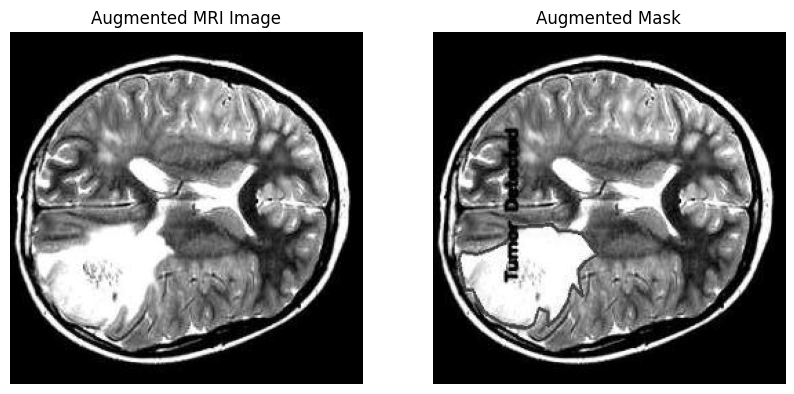

In [16]:
import matplotlib.pyplot as plt

# ✅ Load a sample image and mask to visualize augmentation
sample_img_name = os.listdir(os.path.join(augmented_folder, "images"))[0]
sample_img_path = os.path.join(augmented_folder, "images", sample_img_name)
sample_mask_path = os.path.join(augmented_folder, "masks", sample_img_name)

# ✅ Read image and mask
sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
sample_mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)

# ✅ Display the augmented image and mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap="gray")
plt.title("Augmented MRI Image")
plt.axis("off")
  
plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap="gray")
plt.title("Augmented Mask")
plt.axis("off")

plt.show()
# Augmentation itna perfect hai no changes needed in this MRIdataOverFinal


In [17]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split

# ✅ Define paths for augmented dataset
processed_folder = os.path.join(dataset_path, "Processed_Images")
augmented_images_folder = os.path.join(processed_folder, "augmented/images")
augmented_masks_folder = os.path.join(processed_folder, "augmented/masks")

# ✅ Define train, validation, and test directories
train_folder = os.path.join(processed_folder, "train")
val_folder = os.path.join(processed_folder, "val")
test_folder = os.path.join(processed_folder, "test")

# ✅ Create subdirectories for images and masks
for split in [train_folder, val_folder, test_folder]:
    os.makedirs(os.path.join(split, "images"), exist_ok=True)
    os.makedirs(os.path.join(split, "masks"), exist_ok=True)

# ✅ Get list of augmented image files
image_files = sorted(os.listdir(augmented_images_folder))

# ✅ Ensure masks follow the correct naming pattern
mask_files = sorted(os.listdir(augmented_masks_folder))

# ✅ Filter only matching "aug_" files
image_files = [f for f in image_files if f.startswith("aug_")]
mask_files = [f for f in mask_files if f.startswith("aug_")]

# ✅ Ensure we are only working with matching image-mask pairs
image_files = [f for f in image_files if f in mask_files]

# ✅ Split into train, validation, and test sets (80%-10%-10%)
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

# ✅ Function to move images and masks into respective folders
def move_files(file_list, src_img_folder, src_mask_folder, dest_folder):
    for file_name in file_list:
        img_src = os.path.join(src_img_folder, file_name)
        mask_src = os.path.join(src_mask_folder, file_name)

        img_dest = os.path.join(dest_folder, "images", file_name)
        mask_dest = os.path.join(dest_folder, "masks", file_name)

        # ✅ Check if files exist before copying
        if not os.path.exists(img_src):
            print(f"⚠️ Missing Image: {img_src}")
            continue
        if not os.path.exists(mask_src):
            print(f"⚠️ Missing Mask: {mask_src}")
            continue

        shutil.copy(img_src, img_dest)
        shutil.copy(mask_src, mask_dest)
        print(f"✅ Copied: {img_src} → {img_dest}")
        print(f"✅ Copied: {mask_src} → {mask_dest}")

# ✅ Move files to respective sets
move_files(train_files, augmented_images_folder, augmented_masks_folder, train_folder)
move_files(val_files, augmented_images_folder, augmented_masks_folder, val_folder)
move_files(test_files, augmented_images_folder, augmented_masks_folder, test_folder)

# ✅ Verify dataset split
train_img_count = len(os.listdir(os.path.join(train_folder, "images")))
val_img_count = len(os.listdir(os.path.join(val_folder, "images")))
test_img_count = len(os.listdir(os.path.join(test_folder, "images")))

print(f"✅ Train dataset: {train_img_count} images")
print(f"✅ Validation dataset: {val_img_count} images")
print(f"✅ Test dataset: {test_img_count} images")

print(f"✅ Dataset split complete! Images saved in:")
print(f"   📂 {train_folder}")
print(f"   📂 {val_folder}")
print(f"   📂 {test_folder}")


✅ Copied: C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\augmented/images\aug_y653.jpg → C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\train\images\aug_y653.jpg
✅ Copied: C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\augmented/masks\aug_y653.jpg → C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\train\masks\aug_y653.jpg
✅ Copied: C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\augmented/images\aug_y395.jpg → C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\train\images\aug_y395.jpg
✅ Copied: C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\augmented/masks\aug_y395.jpg → C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\Processed_Images\train\masks\aug_y395.jpg
✅ Copied: C:\Users\Suraj Yadav\FinalProjectTest\datasetMRI\Br35H-Mask-RCNN\P

In [18]:
import os

# ✅ Define dataset directories
train_images_path = os.path.join(processed_folder, "train/images")
train_masks_path = os.path.join(processed_folder, "train/masks")

val_images_path = os.path.join(processed_folder, "val/images")
val_masks_path = os.path.join(processed_folder, "val/masks")

test_images_path = os.path.join(processed_folder, "test/images")
test_masks_path = os.path.join(processed_folder, "test/masks")

# ✅ Count images in each set
print(f"📂 Train: {len(os.listdir(train_images_path))} images")
print(f"📂 Validation: {len(os.listdir(val_images_path))} images")
print(f"📂 Test: {len(os.listdir(test_images_path))} images")


📂 Train: 640 images
📂 Validation: 80 images
📂 Test: 81 images


In [19]:
import os
import numpy as np
import cv2
import tensorflow as tf

# ✅ Define dataset directories
train_images_path = os.path.join(processed_folder, "train/images")
train_masks_path = os.path.join(processed_folder, "train/masks")

val_images_path = os.path.join(processed_folder, "val/images")
val_masks_path = os.path.join(processed_folder, "val/masks")

test_images_path = os.path.join(processed_folder, "test/images")
test_masks_path = os.path.join(processed_folder, "test/masks")

# ✅ Function to Load Images & Masks
def load_data(image_folder, mask_folder):
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

    images, masks = [], []
    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize

        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# ✅ Load Train, Val, Test Data
X_train, Y_train = load_data(train_images_path, train_masks_path)
X_val, Y_val = load_data(val_images_path, val_masks_path)
X_test, Y_test = load_data(test_images_path, test_masks_path)

# ✅ Print dataset shapes
print(f"✅ Dataset Loaded:")
print(f"   - Train: {X_train.shape}, {Y_train.shape}")
print(f"   - Validation: {X_val.shape}, {Y_val.shape}")
print(f"   - Test: {X_test.shape}, {Y_test.shape}")


✅ Dataset Loaded:
   - Train: (640, 256, 256, 1), (640, 256, 256, 1)
   - Validation: (80, 256, 256, 1), (80, 256, 256, 1)
   - Test: (81, 256, 256, 1), (81, 256, 256, 1)


In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

# ✅ Function to Build U-Net Model
def build_unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# ✅ Initialize U-Net Model
unet_model = build_unet()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss="binary_crossentropy",
                   metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)])

unet_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [33]:
# ✅ Train U-Net Model
history = unet_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,  # Adjust based on performance
    batch_size=8,  # Adjust based on available memory
    verbose=1
)

print("✅ Model training completed successfully!")


Epoch 1/20
80/80 [==============================] - 1777s 22s/step - loss: 0.4148 - accuracy: 0.1235 - mean_io_u: 0.4901 - val_loss: 0.4158 - val_accuracy: 0.1377 - val_mean_io_u: 0.4891
Epoch 2/20
80/80 [==============================] - 1841s 23s/step - loss: 0.4114 - accuracy: 0.1235 - mean_io_u: 0.4901 - val_loss: 0.4119 - val_accuracy: 0.1377 - val_mean_io_u: 0.4891
Epoch 3/20
80/80 [==============================] - 1958s 24s/step - loss: 0.4090 - accuracy: 0.1235 - mean_io_u: 0.4901 - val_loss: 0.4123 - val_accuracy: 0.1377 - val_mean_io_u: 0.4891
Epoch 4/20
80/80 [==============================] - 2137s 27s/step - loss: 0.4079 - accuracy: 0.1235 - mean_io_u: 0.4901 - val_loss: 0.4124 - val_accuracy: 0.1377 - val_mean_io_u: 0.4891
Epoch 5/20
80/80 [==============================] - 3150s 40s/step - loss: 0.4090 - accuracy: 0.1235 - mean_io_u: 0.4901 - val_loss: 0.4108 - val_accuracy: 0.1377 - val_mean_io_u: 0.4891
Epoch 6/20
80/80 [==============================] - 2463s 31s/ste

In [21]:
# ✅ Evaluate the model on the test dataset
test_loss, test_accuracy, test_mean_iou = unet_model.evaluate(X_test, Y_test, verbose=1)

print(f"✅ Model Evaluation Results:")
print(f"📉 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"📊 Test Mean IoU: {test_mean_iou:.4f}")


3/3 [==============================] - 69s 19s/step - loss: 0.6964 - accuracy: 0.0744 - mean_io_u: 0.4895
✅ Model Evaluation Results:
📉 Test Loss: 0.6960
✅ Test Accuracy: 0.0792
📊 Test Mean IoU: 0.4904


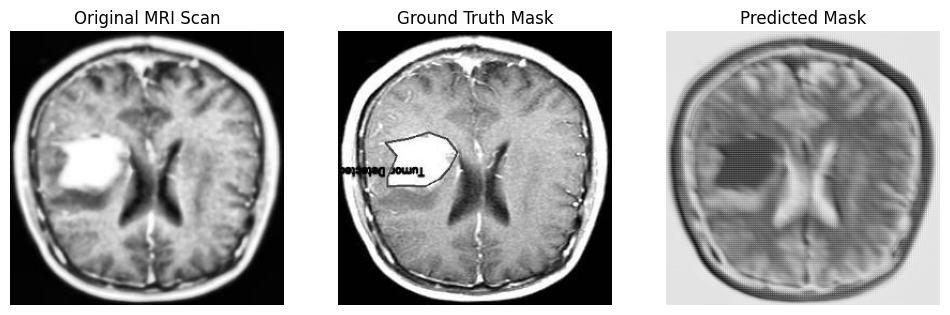

In [61]:
import matplotlib.pyplot as plt

# ✅ Select a random test image
idx = np.random.randint(0, len(X_test))  # Randomly pick an index
test_img = X_test[idx]
test_mask = Y_test[idx]

# ✅ Model prediction
pred_mask = unet_model.predict(np.expand_dims(test_img, axis=0))[0]

# ✅ Convert masks for better visualization
test_img_display = np.squeeze(test_img, axis=-1)
test_mask_display = np.squeeze(test_mask, axis=-1)
pred_mask_display = np.squeeze(pred_mask, axis=-1)

# ✅ Plot Results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_img_display, cmap='gray')
plt.title("Original MRI Scan")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(test_mask_display, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask_display, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


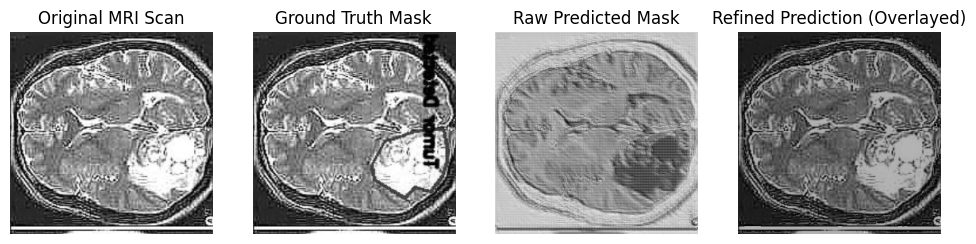

In [63]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ✅ Select a random test image
idx = np.random.randint(0, len(X_test))  # Randomly pick an index
test_img = X_test[idx]
test_mask = Y_test[idx]

# ✅ Model prediction
pred_mask = unet_model.predict(np.expand_dims(test_img, axis=0))[0]

# ✅ Convert masks for better visualization
test_img_display = np.squeeze(test_img, axis=-1)
test_mask_display = np.squeeze(test_mask, axis=-1)
pred_mask_display = np.squeeze(pred_mask, axis=-1)

# ✅ Apply Thresholding (convert soft prediction to binary mask)
threshold = 0.5  # Try different values like 0.3 or 0.7 if needed
binary_mask = (pred_mask_display > threshold).astype(np.uint8)

# ✅ Apply Morphological Operations (Noise Removal and Refinement)
kernel = np.ones((3,3), np.uint8)  # Small kernel to refine the mask
refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# ✅ Convert both images to uint8 type
test_img_uint8 = (test_img_display * 255).astype(np.uint8)  # Scale MRI to 0-255
refined_mask_uint8 = (refined_mask * 255).astype(np.uint8)  # Ensure mask is 0-255

# ✅ Overlay Refined Mask on the Original MRI Scan
overlayed_img = cv2.addWeighted(test_img_uint8, 0.7, refined_mask_uint8, 0.3, 0)

# ✅ Plot Results
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(test_img_display, cmap='gray')
plt.title("Original MRI Scan")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(test_mask_display, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(pred_mask_display, cmap='gray')
plt.title("Raw Predicted Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(overlayed_img, cmap='gray')
plt.title("Refined Prediction (Overlayed)")
plt.axis("off")

plt.show()


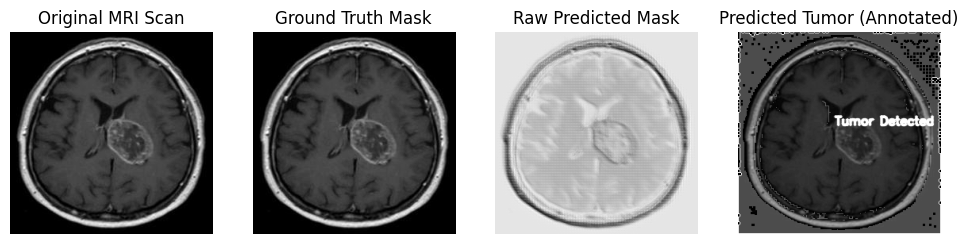

In [87]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ✅ Select a random test image
idx = np.random.randint(0, len(X_test))  # Randomly pick an index
test_img = X_test[idx]
test_mask = Y_test[idx]

# ✅ Model prediction
pred_mask = unet_model.predict(np.expand_dims(test_img, axis=0))[0]

# ✅ Convert masks for better visualization
test_img_display = np.squeeze(test_img, axis=-1)
test_mask_display = np.squeeze(test_mask, axis=-1)
pred_mask_display = np.squeeze(pred_mask, axis=-1)

# ✅ Apply Thresholding (convert soft prediction to binary mask)
threshold = 0.5  # Adjust if needed
binary_mask = (pred_mask_display > threshold).astype(np.uint8)

# ✅ Apply Morphological Operations (Noise Removal and Refinement)
kernel = np.ones((3,3), np.uint8)
refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# ✅ Convert both images to uint8
test_img_uint8 = (test_img_display * 255).astype(np.uint8)
refined_mask_uint8 = (refined_mask * 255).astype(np.uint8)

# ✅ Find Contours in the Predicted Mask
contours, _ = cv2.findContours(refined_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# ✅ Overlay Refined Mask on the Original MRI Scan
overlayed_img = cv2.addWeighted(test_img_uint8, 0.7, refined_mask_uint8, 0.3, 0)

# ✅ Draw Tumor Contour (if found)
if len(contours) > 0:
    cv2.drawContours(overlayed_img, contours, -1, (255, 0, 0), 1)  # Draw in **blue**
    
    # ✅ Add Tumor Label Near the Largest Contour
    c = max(contours, key=cv2.contourArea)  # Pick the largest detected tumor
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(overlayed_img, "Tumor Detected", (cX - 5, cY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

# ✅ Plot Results
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(test_img_display, cmap='gray')
plt.title("Original MRI Scan")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(test_mask_display, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(pred_mask_display, cmap='gray')
plt.title("Raw Predicted Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(overlayed_img, cmap='gray')
plt.title("Predicted Tumor (Annotated)")
plt.axis("off")

plt.show()


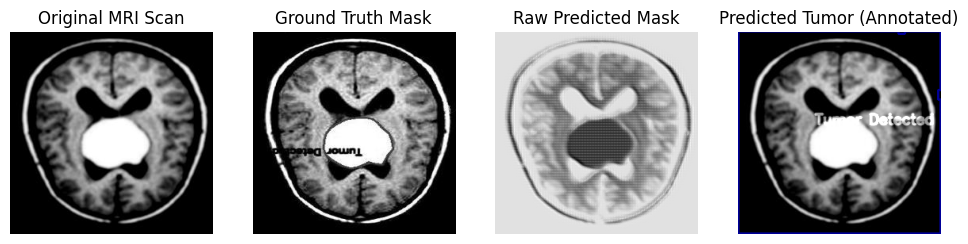

In [88]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ✅ Select a random test image
idx = np.random.randint(0, len(X_test))  # Randomly pick an index
test_img = X_test[idx]
test_mask = Y_test[idx]

# ✅ Model prediction
pred_mask = unet_model.predict(np.expand_dims(test_img, axis=0))[0]

# ✅ Convert masks for better visualization
test_img_display = np.squeeze(test_img, axis=-1)
test_mask_display = np.squeeze(test_mask, axis=-1)
pred_mask_display = np.squeeze(pred_mask, axis=-1)

# ✅ Apply Thresholding (convert soft prediction to binary mask)
threshold = 0.5  # Adjust if needed
binary_mask = (pred_mask_display > threshold).astype(np.uint8)

# ✅ Apply Morphological Operations (Noise Removal and Refinement)
kernel = np.ones((5,5), np.uint8)  # Larger kernel for better shape detection
refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# ✅ Convert both images to uint8
test_img_uint8 = (test_img_display * 255).astype(np.uint8)
refined_mask_uint8 = (refined_mask * 255).astype(np.uint8)

# ✅ Find Contours in the Predicted Mask
contours, _ = cv2.findContours(refined_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# ✅ Overlay Refined Mask on the Original MRI Scan
overlayed_img = cv2.cvtColor(test_img_uint8, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR
overlay_mask = np.zeros_like(overlayed_img)  # Empty mask for overlay

# ✅ Draw Tumor Contour and Add Annotation
if len(contours) > 0:
    c = max(contours, key=cv2.contourArea)  # Select the largest detected tumor
    cv2.drawContours(overlay_mask, [c], -1, (0, 0, 255), 2)  # Draw tumor border in **red**
    
    # ✅ Find centroid for label placement
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(overlay_mask, "Tumor Detected", (cX - 30, cY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

# ✅ Merge overlay with the original image
overlayed_img = cv2.addWeighted(overlayed_img, 1, overlay_mask, 0.6, 0)

# ✅ Plot Results
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(test_img_display, cmap='gray')
plt.title("Original MRI Scan")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(test_mask_display, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(pred_mask_display, cmap='gray')
plt.title("Raw Predicted Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(overlayed_img)
plt.title("Predicted Tumor (Annotated)")
plt.axis("off")

plt.show()


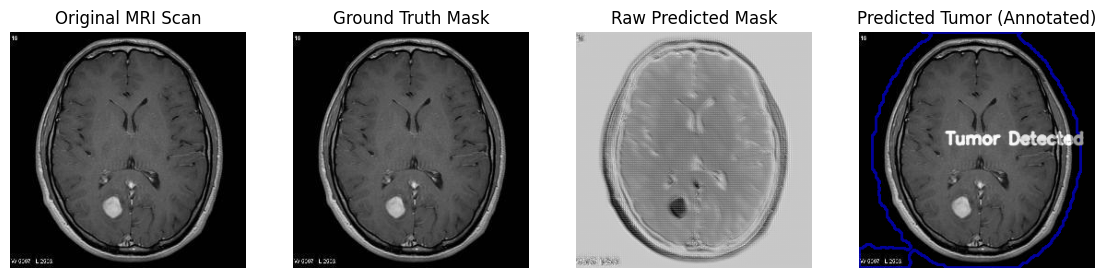

In [101]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ✅ Select a random test image
idx = np.random.randint(0, len(X_test))  # Randomly pick an index
test_img = X_test[idx]
test_mask = Y_test[idx]

# ✅ Model prediction
pred_mask = unet_model.predict(np.expand_dims(test_img, axis=0))[0]

# ✅ Convert masks for better visualization
test_img_display = np.squeeze(test_img, axis=-1)
test_mask_display = np.squeeze(test_mask, axis=-1)
pred_mask_display = np.squeeze(pred_mask, axis=-1)

# ✅ Apply Thresholding to Convert Soft Mask to Binary
threshold = 0.5  # Adjust this value if needed
binary_mask = (pred_mask_display > threshold).astype(np.uint8)

# ✅ Apply Morphological Processing
kernel = np.ones((5, 5), np.uint8)  # Structuring element for morphological ops
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)  # Remove small holes
binary_mask = cv2.medianBlur(binary_mask, 5)  # Further smooth the mask

# ✅ Convert Images to uint8 for OpenCV Processing
test_img_uint8 = (test_img_display * 255).astype(np.uint8)
binary_mask_uint8 = (binary_mask * 255).astype(np.uint8)

# ✅ Find Contours in the Processed Mask
contours, _ = cv2.findContours(binary_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# ✅ Filter Contours - Remove Small Noises and Borders
min_area = 250  # Ignore very small segments
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_area]

# ✅ Overlay Refined Mask on the Original MRI Scan
overlayed_img = cv2.cvtColor(test_img_uint8, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR
overlay_mask = np.zeros_like(overlayed_img)  # Empty mask for overlay

# ✅ Draw Tumor Contour and Add Annotation
if len(filtered_contours) > 0:
    # Select the **largest** tumor region
    largest_tumor = max(filtered_contours, key=cv2.contourArea)

    # **Draw the tumor contour**
    cv2.drawContours(overlay_mask, [largest_tumor], -1, (0, 0, 255), 2)  # **Red Tumor Border**

    # ✅ Find Centroid for Label Placement
    M = cv2.moments(largest_tumor)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        # **Ensure text is inside the tumor region**
        cX = max(30, min(cX, overlay_mask.shape[1] - 50))
        cY = max(30, min(cY, overlay_mask.shape[0] - 20))

        # ✅ Place Tumor Label in the Center
        cv2.putText(overlay_mask, "Tumor Detected", (cX - 30, cY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

# ✅ Merge Overlay with the Original Image
overlayed_img = cv2.addWeighted(overlayed_img, 1, overlay_mask, 0.6, 0)

# ✅ Plot Results
plt.figure(figsize=(14, 6))

plt.subplot(1, 4, 1)
plt.imshow(test_img_display, cmap='gray')
plt.title("Original MRI Scan")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(test_mask_display, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(pred_mask_display, cmap='gray')
plt.title("Raw Predicted Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(overlayed_img)
plt.title("Predicted Tumor (Annotated)")
plt.axis("off")

plt.show()
